In [64]:
MAX_FRAMES = 200
PATH = "./cornell"

# is the path tracing method inside the errors.json?
HAS_PATH = False

In [65]:
import json
import numpy as np
import matplotlib.pyplot as plt

In [66]:
def to_numpy(conf):
    for e, values in conf.items():
        conf[e] = np.array(values)

    return conf

file = json.load(open("{}/errors.json".format(PATH)))
confs = file["errors"]
hero = to_numpy(confs["hero"])
random = to_numpy(confs["random"])
if "path" in confs:
    path = to_numpy(confs["path"])
else:
    path = None

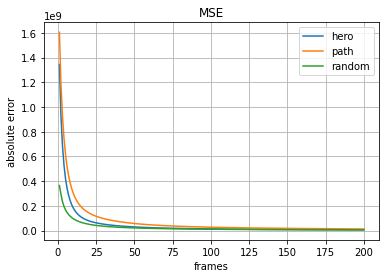

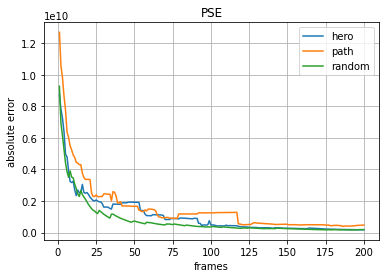

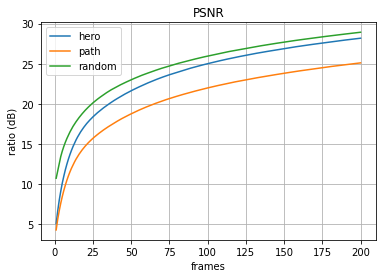

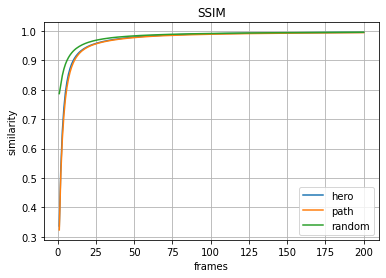

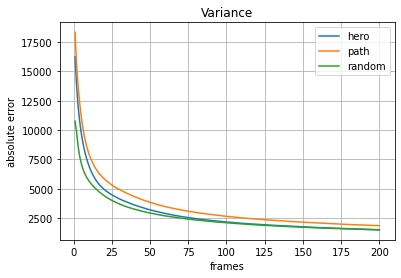

In [67]:
# Raw error plots

def plot_conf(plots, conf, label):
    for e, y in conf.items():
        max_len = np.minimum(len(y), MAX_FRAMES)
        y = y[:max_len]
        x = np.arange(1, len(y) + 1)

        if label == "hero":
            color = "tab:blue"
        elif label == "random":
            color = "tab:orange"
        else:
            color = "tab:green"

        ax = plots[e][1]
        ax.plot(x, y, label=label, color=color)

        ax.grid(visible=True)
        ax.set_xlabel('frames')
        ax.set_title("Variance" if e == "VAR" else e)

        handles,labels = ax.get_legend_handles_labels()
        handels, labels = zip(*sorted(zip(handles, labels), key=lambda t: t[1]))
        ax.legend(handles, labels)

        if e == "SSIM":
            ax.set_ylabel("similarity")
        elif e == "PSNR":
            ax.set_ylabel("ratio (dB)")
        else:
            ax.set_ylabel("absolute error")

error_plots = {
    "MSE": plt.subplots(),
    "PSE": plt.subplots(),
    "PSNR": plt.subplots(),
    "SSIM": plt.subplots(),
    "VAR": plt.subplots(),
}

plot_conf(error_plots, hero, "hero")
plot_conf(error_plots, random, "random")
if path is not None:
    plot_conf(error_plots, path, "path")

for e, p in error_plots.items():
    p[0].savefig("{}/{}.png".format(PATH, "Variance" if e == "VAR" else e), dpi=200)

plt.show()

PSNR ratio in range (0.835, 0.913).
SSIM ratio in range (0.960, 1.000).
VAR ratio in range (0.815, 0.886).
MSE ratio in range (0.489, 0.837).


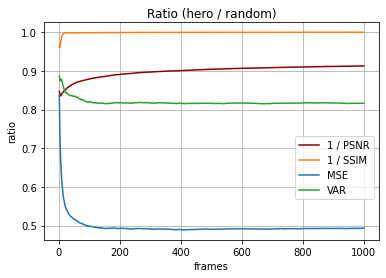

In [68]:
# ratio plots
#size = plt.rcParamsDefault["figure.figsize"]
#plt.figure(figsize=(size[0] * 2, size[1]))

fig, ax = plt.subplots()

for e, hero_y in hero.items():
    if e == "PSE":
        continue
    if e == "PSNR" or e == "SSIM":
        label = "1 / " + e
        ratio = random[e] / hero_y
    else:
        label = e
        ratio = hero_y / random[e]

    if e == "PSNR":
        color = "darkred"
    elif e == "SSIM":
        color = "tab:orange"
    elif e == "MSE":
        color = "tab:blue"
    else:
        color = "tab:green"

    x = np.arange(1, len(ratio) + 1)
    ax.plot(x, ratio, label=label, color=color)

    print("{} ratio in range ({:.3f}, {:.3f}).".format(e, ratio.min(), ratio.max()))
    # if e == "VAR":
    #     print(hero_y[:10]);
    #     print(random[e][:10]);
    #     print(ratio[:10])

ax.grid(visible=True)
ax.set_xlabel("frames")
ax.set_ylabel("ratio")
ax.set_title("Ratio (hero / random)")

handles,labels = ax.get_legend_handles_labels()
handels, labels = zip(*sorted(zip(handles, labels), key=lambda t: t[1]))
ax.legend(handels, labels, loc="best", bbox_to_anchor=(0.5, 0, 0.5, 0.5))

fig.savefig("{}/ratio.png".format(PATH), dpi=200)
plt.show()